In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from numpy import ndarray
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import libs.ds_charts as ds

# Missing values imputation

In [34]:
dataset_2 = pd.read_csv('dataset_2/air_quality_tabular.csv', na_values='NaN')
new_dataset_2 = dataset_2.copy()

#FIND VARIABLES WITH MISSING VALUES
mv = {}
for var in new_dataset_2:
    nr = new_dataset_2[var].isna().sum()
    if nr > 0:
        mv[var] = nr

#DISCARD COLUMNS WITH MORE THEN 90% MISSING VALUES
threshold = new_dataset_2.shape[0] * 0.90

missings = [c for c in mv.keys() if mv[c]>threshold]
new_dataset_2.drop(columns=missings, inplace=True)
print('Dropped variables', missings)

#DISCARD RECORDS WITH MAJORITY OF MISSING VALUES
threshold = new_dataset_2.shape[1] * 0.50

new_dataset_2.dropna(thresh=threshold, inplace=True)
print(new_dataset_2.shape)

for column in mv:
    if column != "Field_1":
        vars = dataset_2[column]
        mean_vars = int(vars.mean())
        dataset_2[column].fillna(mean_vars,inplace=True)
    # else: # VER FIELD_1

Dropped variables []
(161631, 32)


# Dummification

In [35]:
file = 'air_quality'
filename = 'data/air_quality.csv'
symbolic_vars = ['City_EN', 'Prov_EN']

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)

    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

variables = ds.get_variable_types(new_dataset_2)
new_dataset_2 = dummify(new_dataset_2, symbolic_vars)
new_dataset_2.to_csv(f'data/{file}_dummified.csv', index=False)

new_dataset_2.describe(include=[bool])

,City_EN_Abacangzuqiangzu,City_EN_Akesudiqu,City_EN_Alashan,City_EN_Aletaidiqu,City_EN_Alidiqu,City_EN_Ankang,City_EN_Anqing,City_EN_Anshan,City_EN_Anshun,City_EN_Anyang,...,Prov_EN_Shaanxi,Prov_EN_Shandong,Prov_EN_Shanghai,Prov_EN_Shanxi,Prov_EN_Sichuan,Prov_EN_Tianjin,Prov_EN_Xinjiang,Prov_EN_Xizang,Prov_EN_Yunnan,Prov_EN_Zhejiang
count,161631,161631,161631,161631,161631,161631,161631,161631,161631,161631,...,161631,161631,161631,161631,161631,161631,161631,161631,161631,161631
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,161265,161182,161182,161182,161182,161182,161182,161182,161182,161182,...,157141,149151,161182,156692,152451,161182,154878,158489,154450,155016


## Scalling

In [36]:
variable_types = ds.get_variable_types(new_dataset_2)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = new_dataset_2[numeric_vars]
df_sb = new_dataset_2[symbolic_vars]
df_bool = new_dataset_2[boolean_vars]

In [37]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=new_dataset_2.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)
norm_data_zscore.to_csv(f'data/{file}_scaled_zscore.csv', index=False)

                  FID         GbProv        Field_1        CO_Mean  \
count   161631.000000  161631.000000  146109.000000  161493.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.056100       0.531791       0.500666       0.021682   
std          0.179099       0.268519       0.289908       0.012289   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000138       0.388889       0.248521       0.014260   
50%          0.000279       0.555556       0.500000       0.019275   
75%          0.000423       0.740741       0.754438       0.025894   
max          1.000000       1.000000       1.000000       1.000000   

               CO_Min         CO_Max         CO_Std       NO2_Mean  \
count   161494.000000  161495.000000  161494.000000  161570.000000   
unique            N

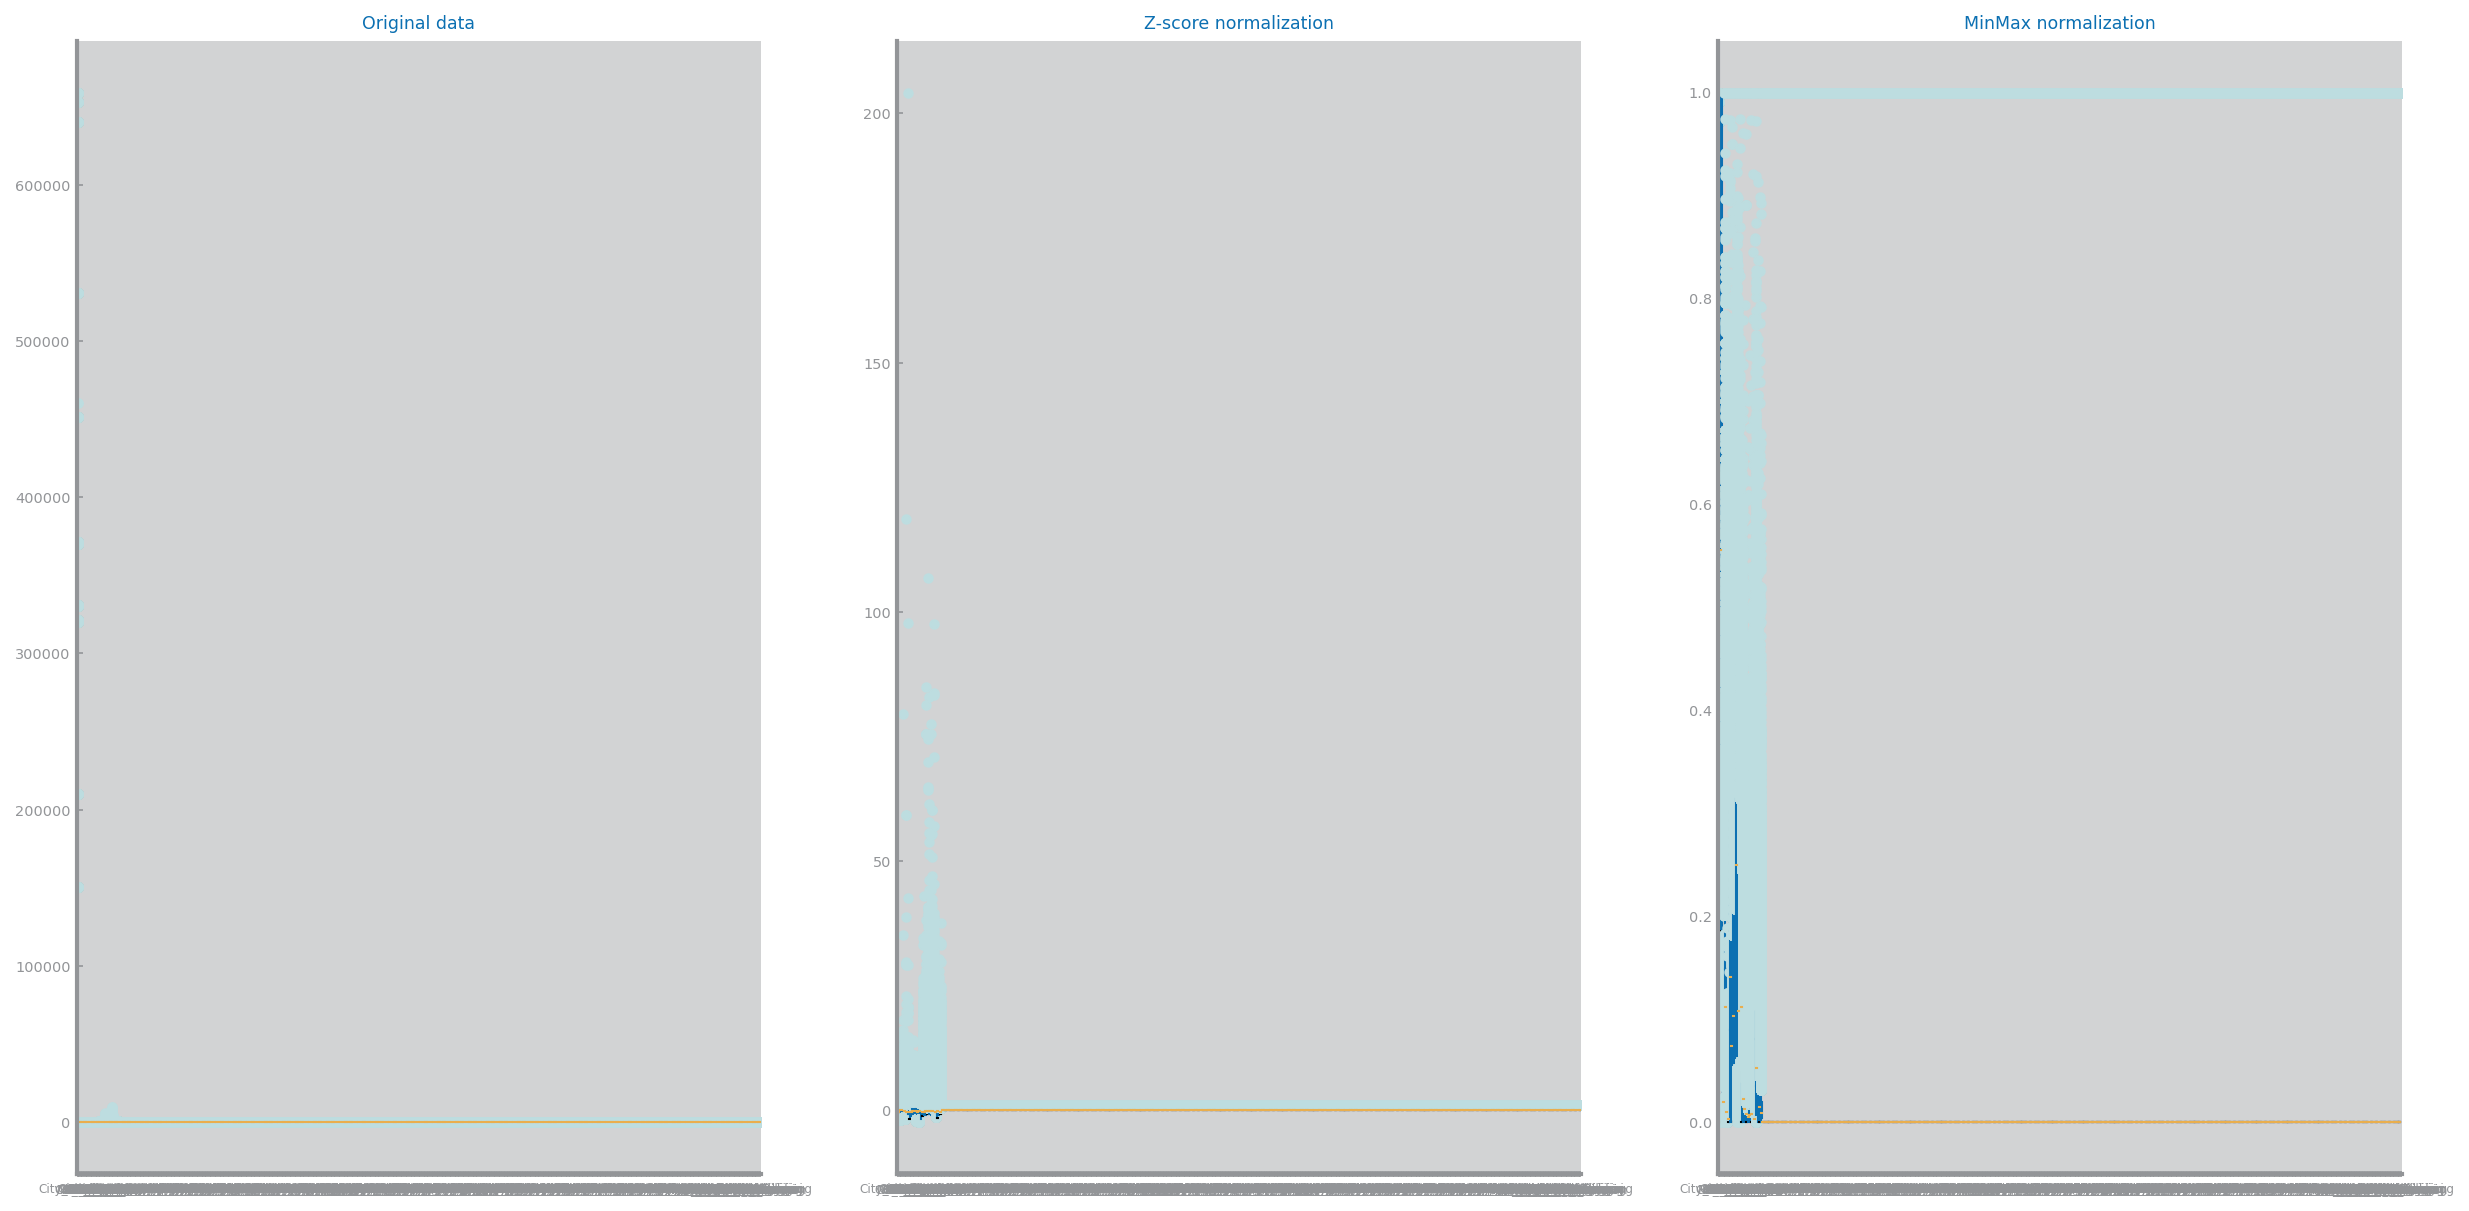

In [38]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=new_dataset_2.index, columns= numeric_vars)
norm_data_minmax = concat([tmp, df_sb,  df_bool], axis=1)
norm_data_minmax.to_csv(f'data/{file}_scaled_minmax.csv', index=False)
print(norm_data_minmax.describe())

from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
new_dataset_2.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
show()

norm_data_zscore.to_csv('data/air_quality_scaled_zscore.csv', index=False)

## Train And Test

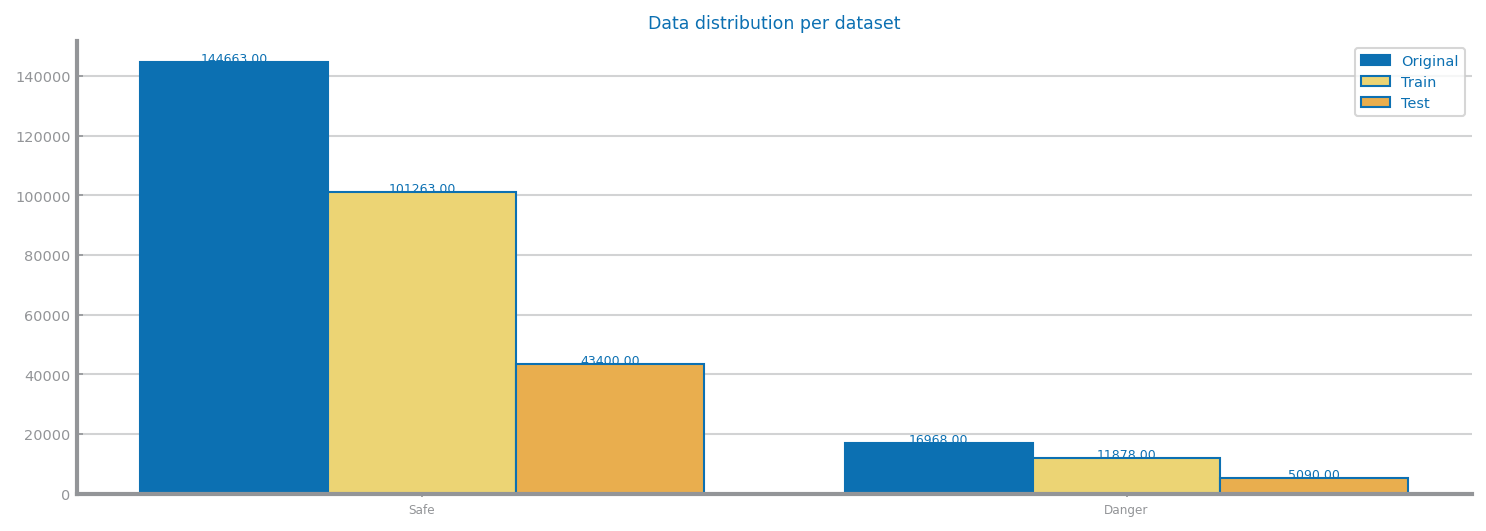

In [39]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_tag = 'air_quality_scaled_zscore'
data: DataFrame = read_csv('data/air_quality_scaled_zscore.csv')
target = 'ALARM'
positive = 'Safe'
negative = 'Danger'
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/{file_tag}_train.csv', index=False)

test = concat([DataFrame(tstX, columns=data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/{file_tag}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

In [41]:
'''
file = 'air_quality'
filename = 'data/air_quality.csv'
symbolic_vars = ['City_EN', 'Prov_EN']
'''
target = 'ALARM' #ou class?\
filename = 'air_quality_scaled_zscore'
# versao ir buscar dados normalizados
train: DataFrame = pd.read_csv(f'data/{filename}_train.csv')
train.drop(['date','FID'],axis=1,inplace=True)
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: DataFrame = pd.read_csv(f'data/{filename}_test.csv')
test.drop(['date','FID'],axis=1,inplace=True)
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.savefig('images/{file_tag}_knn_study.png')
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

ValueError: could not convert string to float: 's'

In [ ]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig('images/{file_tag}_knn_best.png')
show()